# Delaunay Triangulation Neighborhood

In this notebook I am testing whether one could use the Delaunay Triangulation to build a confusion and neighborhood graph.

The idea is the following. Using the Delaunay Triangulation graph, the confusion neighborhood set of a label `L` is simply the set of all neighbors of points in `L`. The neighborhood of `L` is defined as all the points reachable in three steps from points in `L` excluding the confusion set.

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import Delaunay

from cev.test_cases.confusion import (
    case1,
    case2,
    case3,
    case4,
    case5,
    plot_confusion,
)

plt.style.use("dark_background")

In [14]:
from typing import Callable, Literal, Union
from cev.metrics import count_neighbor_labels


def process_bags(
    labels: pd.Series,
    indices_bags: dict[str, np.ndarray],
    type: Literal["incoming", "outgoing", "both"],
    agg: Literal["set", "sum"],
):
    # flatten
    outgoing = {k: v.ravel() for k, v in indices_bags.items()}

    if type == "outgoing":
        bags = outgoing
    else:
        # incoming or both
        incoming = {}
        for label in indices_bags:
            bag = []
            for other, out_inds in indices_bags.items():
                in_inds = np.where(labels == other)[0]

                if label == other:
                    continue

                mask = np.any(labels.values[out_inds] == label, axis=1)
                bag.append(in_inds[mask])
            incoming[label] = np.concatenate(bag)

        if type == "incoming":
            bags = incoming
        else:
            bags = {}
            for k in outgoing:
                bags[k] = np.concatenate((outgoing[k], incoming[k]))

    if agg == "set":
        bags = {k: np.unique(v) for k, v in bags.items()}

    index = pd.Series(bags.keys(), name="label", dtype="category")
    df = pd.DataFrame(
        np.stack([labels.values[v].value_counts() for v in bags.values()]),
        index=index,
    )
    df.columns = index.values
    return df


def kneighbors(X: np.ndarray, k: int) -> np.ndarray:
    nn = NearestNeighbors(n_neighbors=k).fit(X)
    return nn.kneighbors(return_distance=False)


def fixed_k(df: pd.DataFrame, k: int):
    knn_indices = kneighbors(df[["x", "y"]].values, k=k)
    counts = count_neighbor_labels(knn_indices, df.label)
    index = pd.Series(df.label, name="label", dtype="category")

    result = pd.DataFrame(counts, index=index).groupby("label").sum()
    result.columns = result.index
    return result


def dynamic_k(
    df: pd.DataFrame,
    compute_k: Callable[[int], int] = lambda size: int(np.ceil(np.log2(size + 1))),
    kind: Literal["set", "sum"] = "set",
    knn_indices: Union[np.ndarray, None] = None,
):
    sizes = df.label.value_counts(sort=True)

    if knn_indices is None:
        knn_indices = kneighbors(
            X=df[["x", "y"]].values,
            k=max(map(compute_k, sizes)),
        )

    indices_bags = {}
    for label in df.label.cat.categories:
        k = compute_k(sizes.loc[label])
        label_knn_indices = knn_indices[df.label.values == label, 0:k]
        indices_bags[label] = label_knn_indices.ravel()

    return process_bags(
        labels=df.label, indices_bags=indices_bags, type="outgoing", agg=kind
    )


from collections import deque


def bfs_neighbors(G, source: int, depth_start: int = 0, depth_end: int = None):
    visited = {source}

    if depth_end is None:
        depth_end = len(G)

    queue = deque([(source, depth_start, G.neighbors(source))])

    while queue:
        parent, depth, children = queue[0]
        try:
            child = next(children)
            if child not in visited:
                visited.add(child)
                if depth < depth_end:
                    yield child
                    queue.append((child, depth + 1, G.neighbors(child)))
        except StopIteration:
            queue.popleft()


def delaunay_confusion(G, point_idxs, depth_start=0, depth_end=1):
    return np.array(
        list(
            set().union(
                *(
                    bfs_neighbors(G, idxs, depth_start=depth_start, depth_end=depth_end)
                    for idxs in point_idxs
                )
            )
        )
    )


def delaunay_neighborhood(G, point_idxs, depth_start=0, depth_end=None):
    confusion_idxs = delaunay_confusion(
        G, point_idxs, depth_start=0, depth_end=depth_start
    )
    neighborhood_idxs = set().union(
        *(
            bfs_neighbors(G, idxs, depth_start=0, depth_end=depth_end)
            for idxs in point_idxs
        )
    )
    return np.array(list(neighborhood_idxs.difference(confusion_idxs)))


from libpysal import weights
from libpysal.cg import voronoi_frames


def get_edge_lengths(df, edges):
    x1y1x2y2 = df.iloc[edges.flatten()][["x", "y"]].values.reshape((len(edges), -1))
    return np.sqrt(
        np.square(x1y1x2y2[:, 0] - x1y1x2y2[:, 2])
        + np.square(x1y1x2y2[:, 1] - x1y1x2y2[:, 3])
    )


def delaunay(
    df: pd.DataFrame,
    neighbors: Callable,
    clip: str = "convex hull",
    labels: list[str] = None,
    max_edge_z_score=None,
):
    labels = labels or df.label.unique()
    num_labels = len(labels)

    cells, generators = voronoi_frames(df[["x", "y"]].values, clip=clip)
    delaunay = weights.Rook.from_dataframe(cells)
    G = delaunay.to_networkx()

    confusion = np.zeros((num_labels, num_labels)).astype(int)

    if max_edge_z_score is not None:
        edges = np.array(G.edges).astype(int)
        edge_lengths = get_edge_lengths(df, edges)
        max_edge_length = (
            np.mean(edge_lengths) + np.std(edge_lengths) * max_edge_z_score
        )
        for edge in edges[np.where(edge_lengths > max_edge_length)[0]]:
            G.remove_edge(edge[0], edge[1])

    for i, label in enumerate(labels):
        neighbor_idxs = neighbors(G, df.query(f'label == "{label}"').index)
        confusion[i] = (
            df.iloc[neighbor_idxs]
            .label.cat.set_categories(labels)
            .value_counts(sort=False)
            .values
        )

    return pd.DataFrame(
        confusion,
        index=pd.Series(labels, name="label", dtype="category"),
        columns=labels,
    )

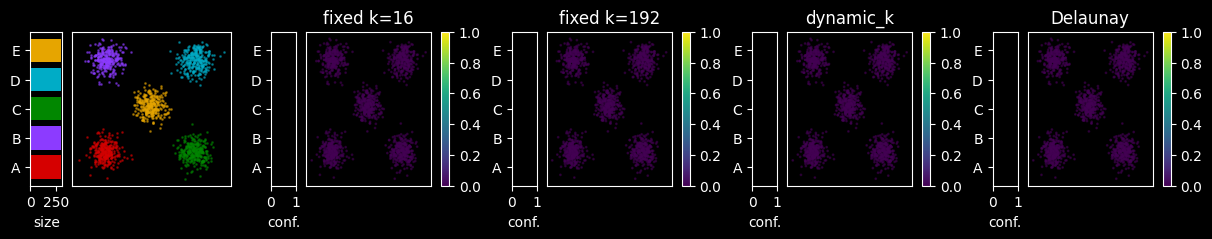

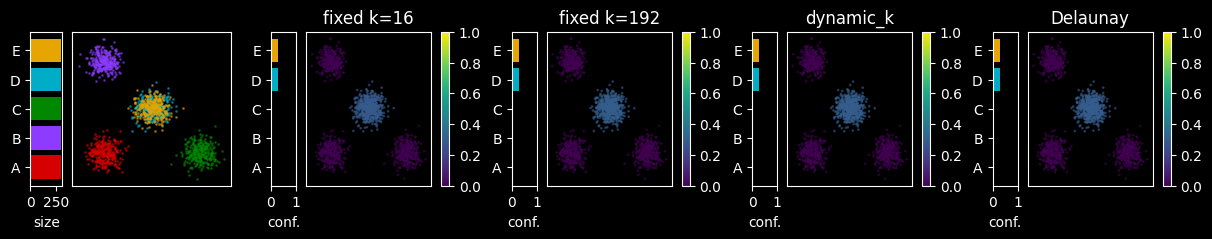

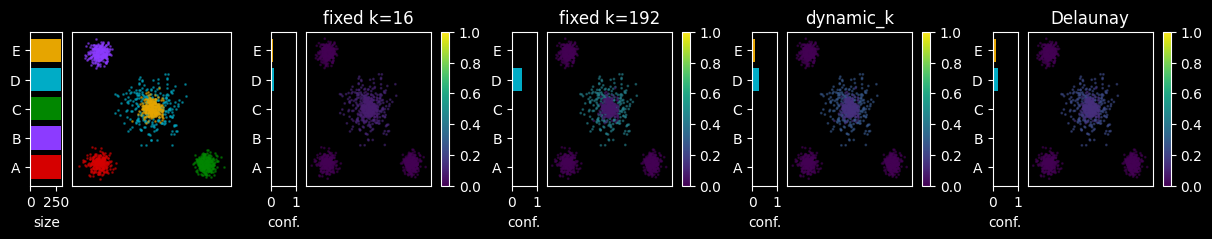

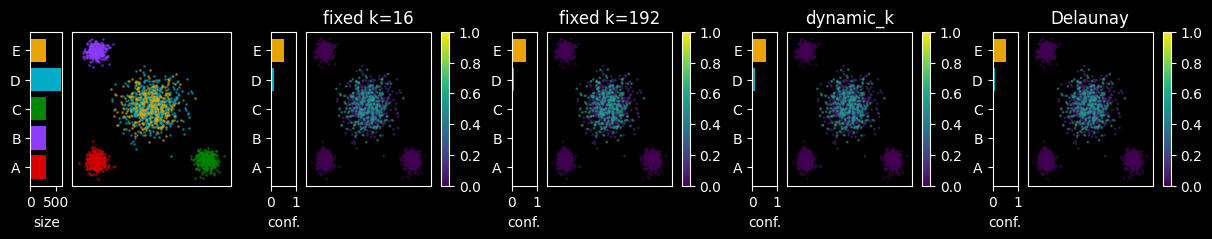

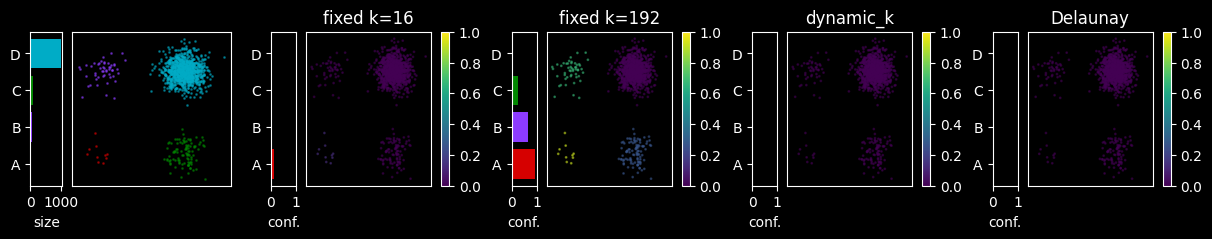

In [15]:
def run_confusion(metrics):
    for case in [case1, case2, case3, case4, case5]:
        plot_confusion(case(), metrics)


run_confusion(
    [
        ("fixed k=16", functools.partial(fixed_k, k=16)),
        ("fixed k=192", functools.partial(fixed_k, k=192)),
        ("dynamic_k", dynamic_k),
        (
            "Delaunay",
            functools.partial(
                delaunay, neighbors=delaunay_confusion, max_edge_z_score=3
            ),
        ),
    ]
)

In [12]:
from cev.test_cases.metrics import count_first, fixed_k
from cev.test_cases.neighborhood import plot_neighborhood


def run_neighborhood(metrics):
    import cev.test_cases.neighborhood as mod

    cases = [
        getattr(mod, name) for name in filter(lambda x: x.startswith("case"), dir(mod))
    ]
    for case in cases:
        plot_neighborhood(
            *case(), metrics=metrics, name=f"{case.__name__}: {case.__doc__}"
        )

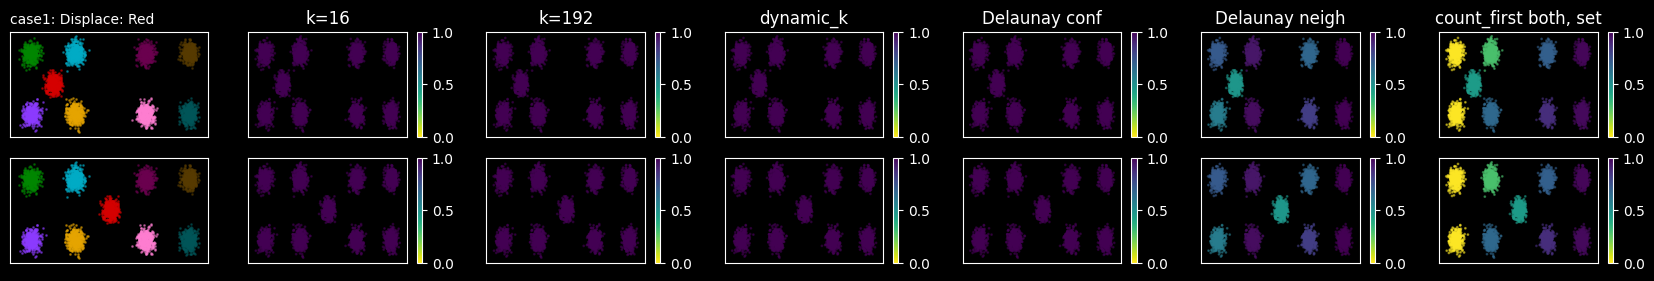

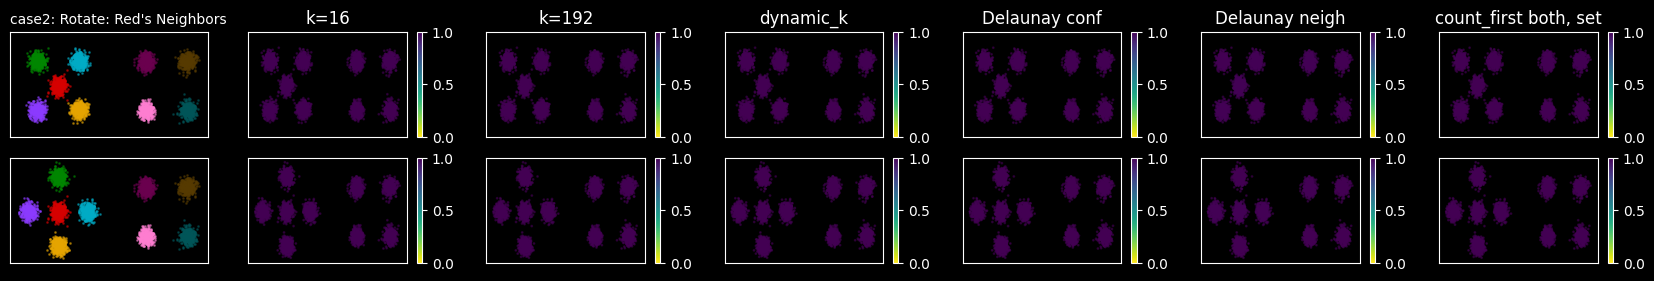

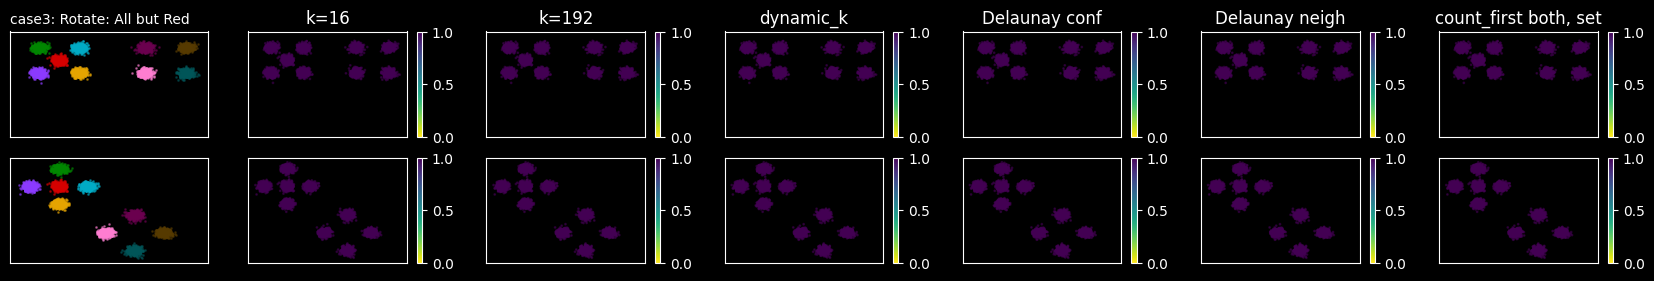

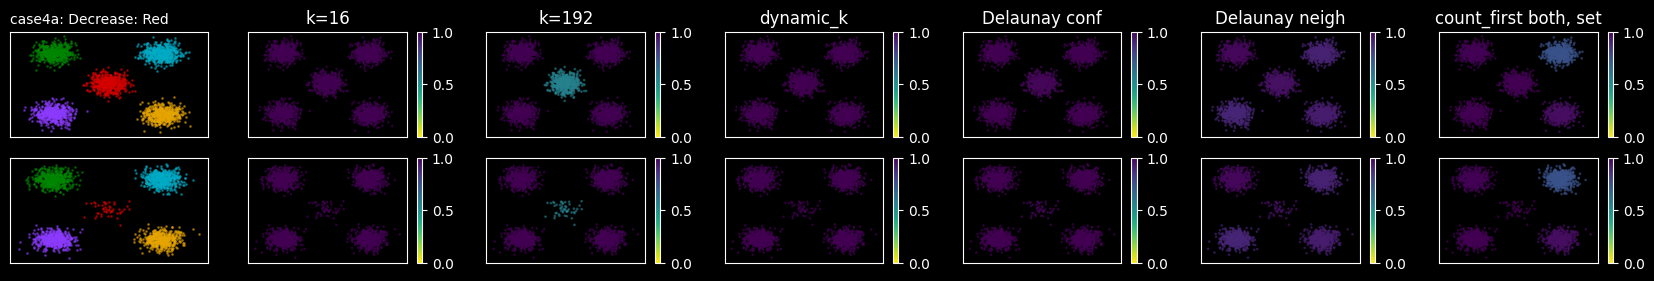

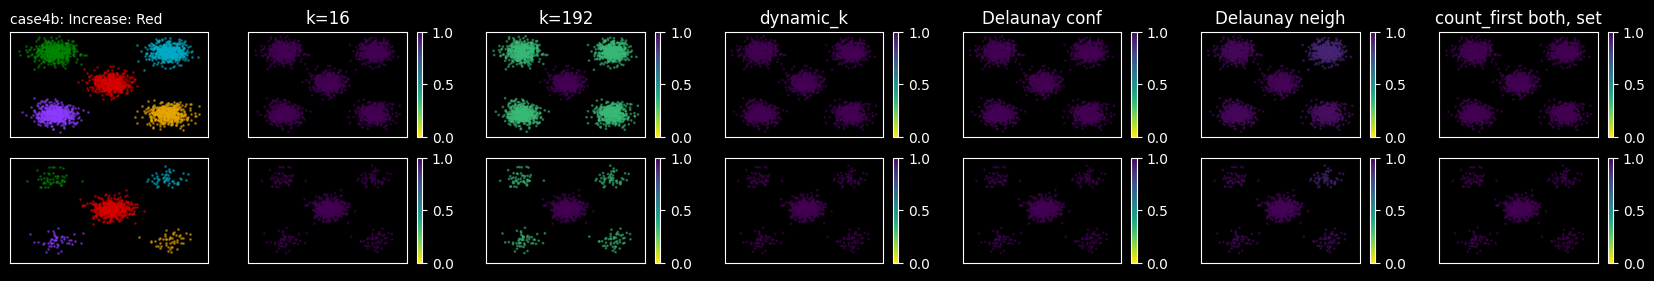

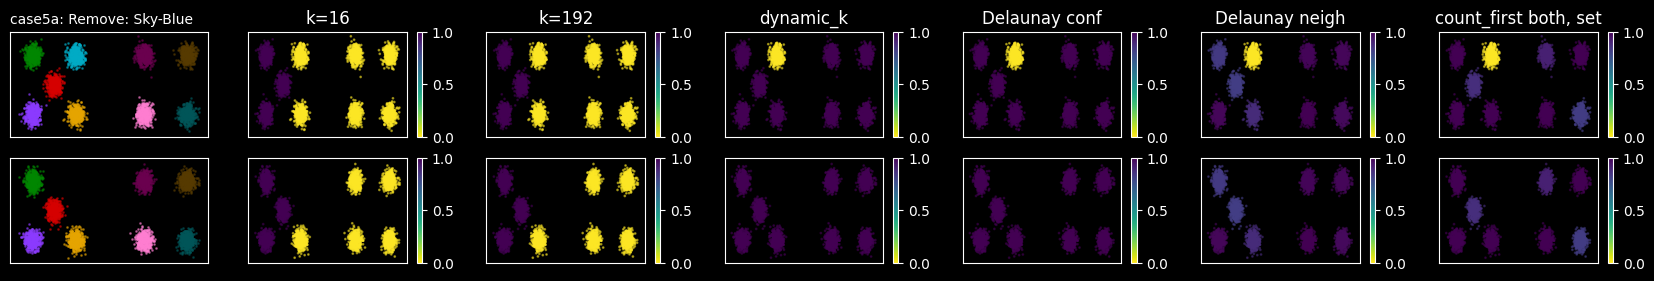

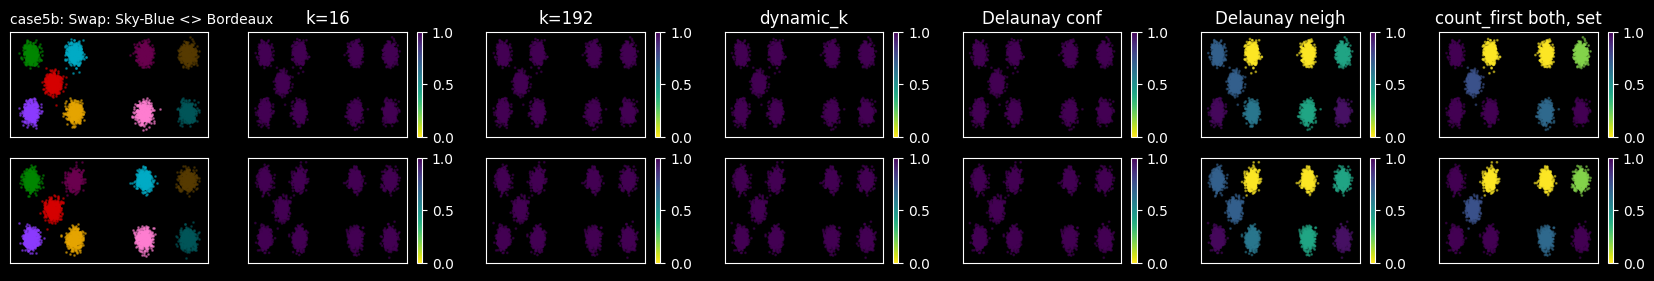

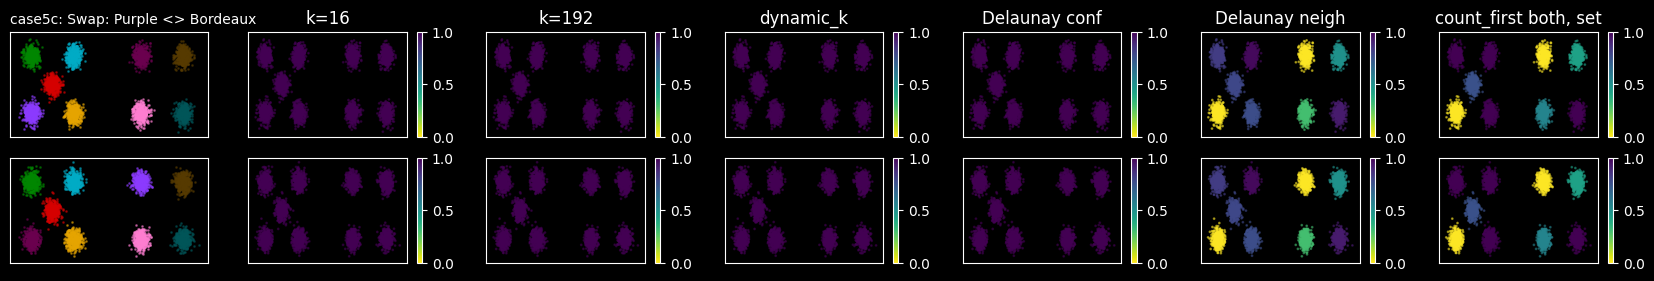

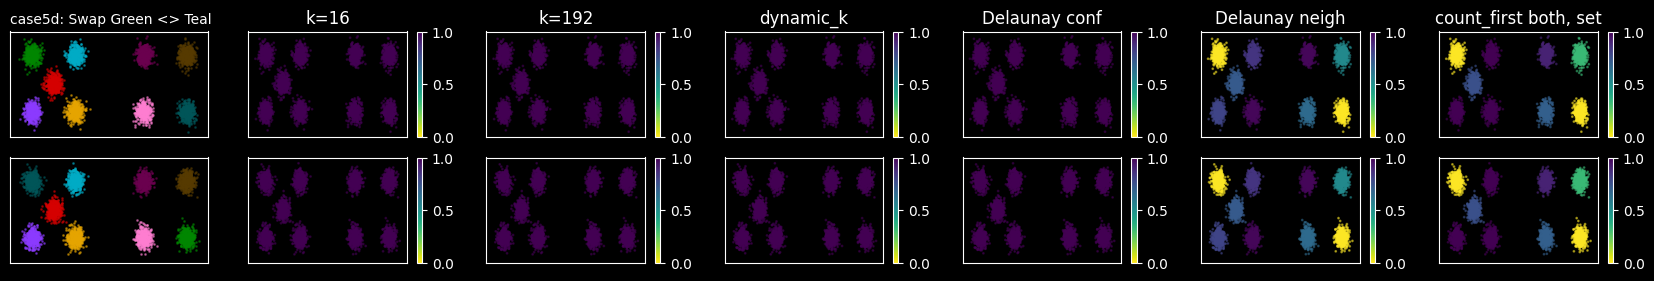

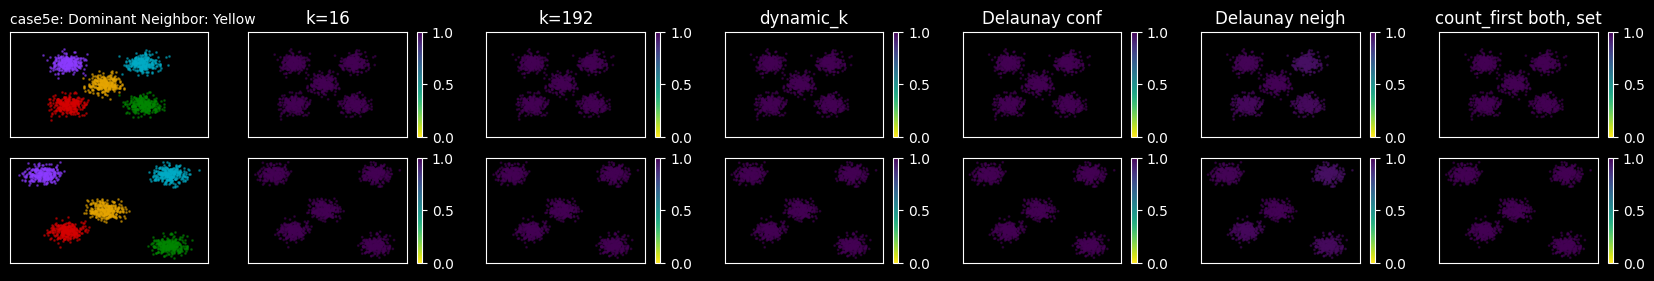

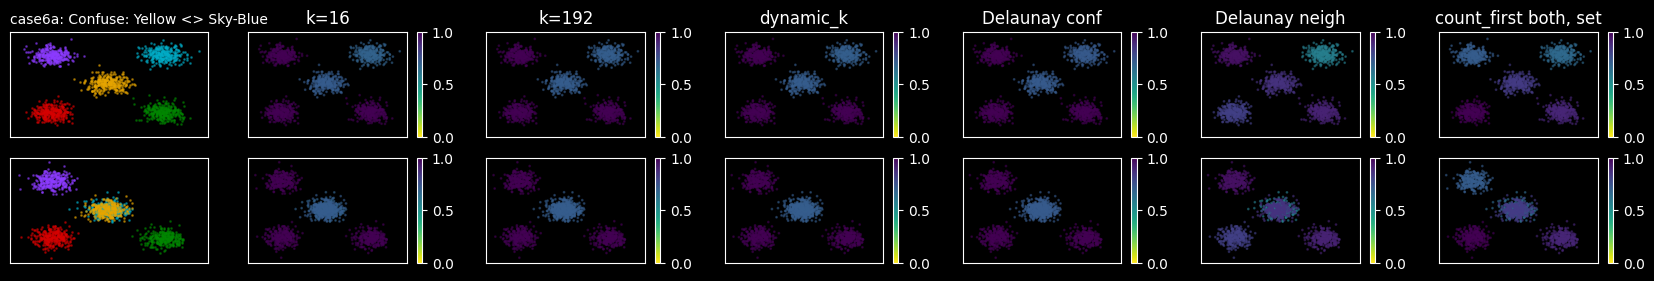

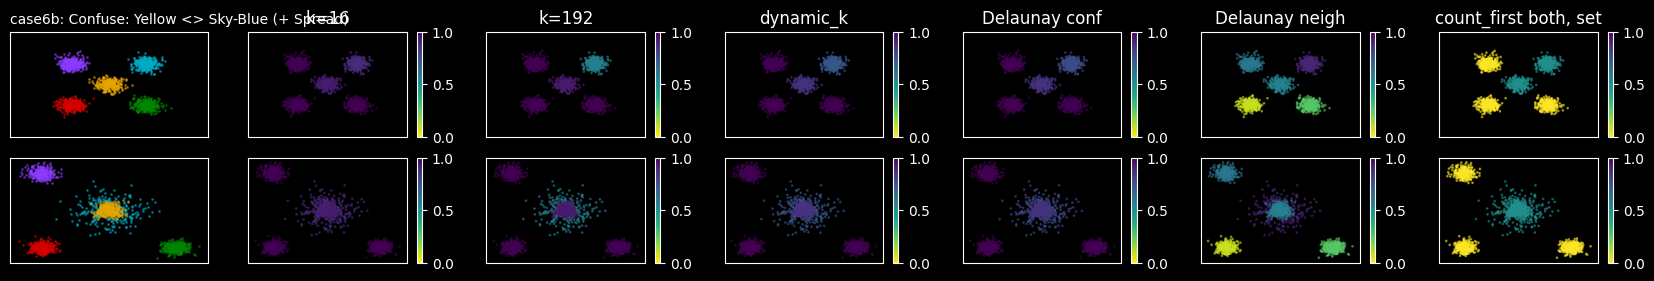

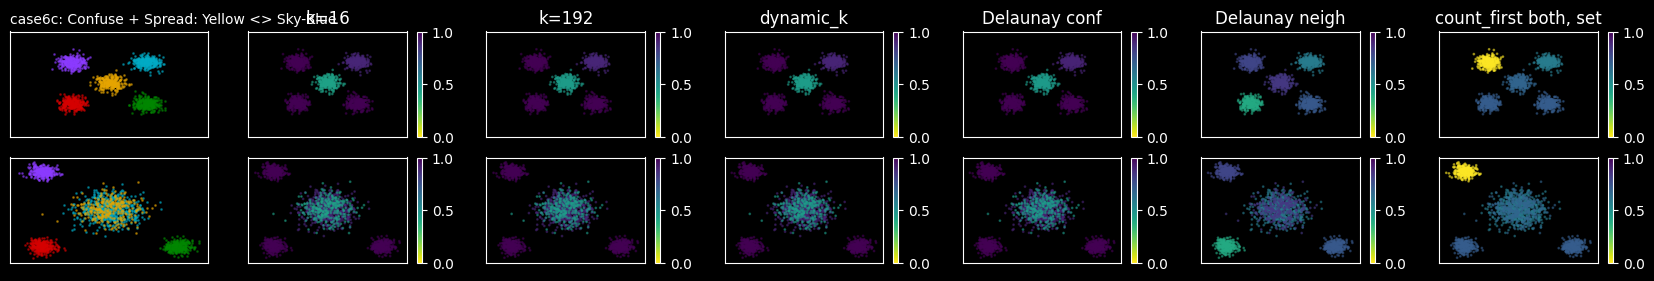

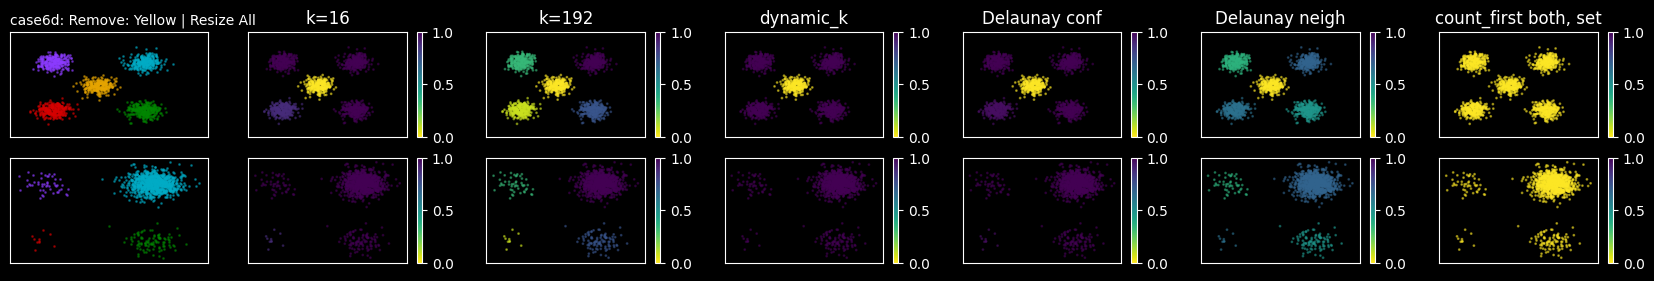

In [13]:
run_neighborhood(
    [
        ("k=16", functools.partial(fixed_k, k=16)),
        ("k=192", functools.partial(fixed_k, k=192)),
        ("dynamic_k", dynamic_k),
        (
            "Delaunay conf",
            functools.partial(
                delaunay,
                labels=list("ABCDEFGHIJKL"),
                neighbors=delaunay_confusion,
                max_edge_z_score=4,
            ),
        ),
        (
            "Delaunay neigh",
            functools.partial(
                delaunay,
                labels=list("ABCDEFGHIJKL"),
                neighbors=functools.partial(
                    delaunay_neighborhood, depth_start=1, depth_end=3
                ),
                max_edge_z_score=4,
            ),
        ),
        (
            "count_first both, set",
            functools.partial(count_first, type="both", agg="set"),
        ),
    ]
)

In [16]:
def init(X) -> Embedding:
    ...


n = 4

labels = [
    ("CD4", pd.Series(["CD4-", "CD4+", "CD4+", "CD4-"], dtype="category")),
    ("CD8", pd.Series(["CD4-CD8+", "CD4+CD8-", "CD4+CD8-", "CD4+CD8-"])),
]

SyntaxError: unterminated string literal (detected at line 7) (3679000141.py, line 7)

In [18]:
s = pd.Series(["a", "b", "b", "c"], dtype="category")
s

0    a
1    b
2    b
3    c
dtype: category
Categories (3, object): ['a', 'b', 'c']

In [20]:
s.cat.codes

0    0
1    1
2    1
3    2
dtype: int8

In [22]:
x = ["CD4-", "CD4+", "CD4+", "CD4-"]
y = pd.Series(x, dtype="category")

In [ ]:
def labeler(level: int, name: str, df: pd.DataFrame) -> (df) -> pd.Series:
    df["label"]...

class Embedding:
    
    ...
    
    def __init__(X, x, y, data):
        self.X = X or data[[x, y]].to_numpy()
        self._data = data
        
    def view(names, fn: Callable[[data, level], pd.Series]):
        ...
        
# option 1        
Embedding(x="y", y="y", data=df).view(names=["a", "b", "c"])


# option 2
X = df[["x", "y"]].values
Embedding(X).view(names=["a", "b", "c"], labeler=lambda level, *args: trim(df["faustLabels"], level))